In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import dipy.data as dpd

In [3]:
from dipy.core.gradients import gradient_table

In [4]:
from dipy.sims.voxel import single_tensor
from dipy.sims.voxel import multi_tensor_dki, multi_tensor

In [5]:
from dipy.reconst.cross_validation import kfold_xval, coeff_of_determination

In [6]:
from dipy.reconst.dti import TensorModel
from dipy.reconst.dki import DiffusionKurtosisModel

In [7]:
def aic(y, y_hat, k, corrected=False):
    """ 
    """
    
    rss = np.sum((y - y_hat)**2, -1)
    AIC = 2 * k + y.shape[-1] * np.log(rss)

    if corrected:
        return AIC + (2 * k * (k + 1)) / (y.shape[-1] - k - 1)
    else:
        return AIC

In [8]:
gtab = gradient_table(
    '/Users/arokem/AFQ_data/HCP_1200/derivatives/dmriprep/sub-100206/ses-01/dwi/sub-100206_dwi.bval',
    '/Users/arokem/AFQ_data/HCP_1200/derivatives/dmriprep/sub-100206/ses-01/dwi/sub-100206_dwi.bvec')

In [9]:
gtab.bvecs.shape

(288, 3)

In [10]:
mevals = np.array([[0.0015, 0.001, 0.001], 
                   [0.001, 0.00015, 0.00015]])

In [11]:
beta = 1

In [12]:
n_sims = 1000

Simulating  dki
Folds:  2
delta-COD:  6.224044375573882
Folds:  5
delta-COD:  6.922090904707495
Folds:  10
delta-COD:  7.492827844610048
delta-AIC:  -179.47423061548807
Simulating  dti
Folds:  2
delta-COD:  -0.38341947288737543
Folds:  5
delta-COD:  -0.19112729516128724
Folds:  10
delta-COD:  -0.15747286492727852
delta-AIC:  42.805897717277176


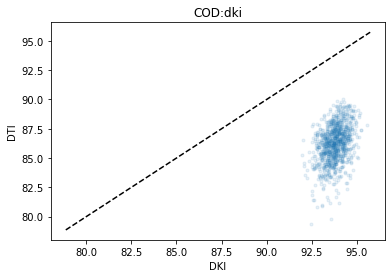

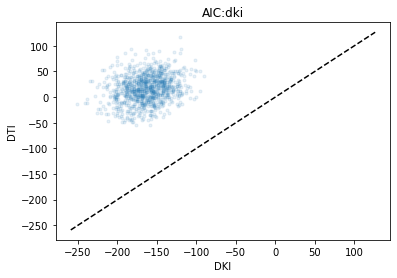

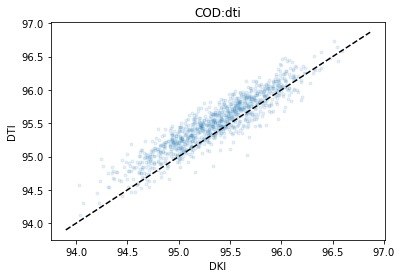

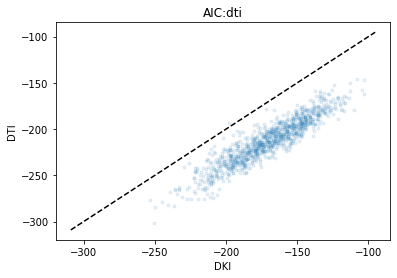

In [14]:
sim = np.zeros((n_sims, gtab.bvals.shape[0]))

for simulation in ['dki', 'dti']:
    print ("Simulating ", simulation)
    sim = np.zeros((n_sims, gtab.bvals.shape[0]))
    for nn in range(n_sims):
        if simulation == "dti":
            sim[nn] = single_tensor(gtab, snr=25)
        elif simulation == "dki":
            sim[nn] = multi_tensor_dki(gtab, snr=25, mevals=mevals)[0] 

    for folds in [2, 5, 10]:
        print("Folds: ", folds)
        dtm = TensorModel(gtab)

        pred_dti = kfold_xval(dtm, sim, folds)

        dkm = DiffusionKurtosisModel(gtab)
        pred_dki = kfold_xval(dkm, sim, folds)

        cod_dki = coeff_of_determination(sim[:, ~gtab.b0s_mask], pred_dki[:,~gtab.b0s_mask])

        cod_dti = coeff_of_determination(sim[:, ~gtab.b0s_mask], pred_dti[:,~gtab.b0s_mask])

        print("delta-COD: ", np.median(cod_dki - cod_dti))

    y = sim[:, ~gtab.b0s_mask]
    y_hat = pred_dki[:,~gtab.b0s_mask]
    rss = np.sum((y - y_hat)**2, -1)

    aic_dki = aic(sim[:, ~gtab.b0s_mask], pred_dki[:,~gtab.b0s_mask], 21, corrected=True)

    aic_dti = aic(sim[:, ~gtab.b0s_mask], pred_dti[:,~gtab.b0s_mask], 6, corrected=True)
    print("delta-AIC: ", np.median(aic_dki - aic_dti))
    fig, ax = plt.subplots()
    ax.plot(cod_dki, cod_dti, '.', alpha=0.1)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()    
    new_lims = [np.min([xlim[0], ylim[0]]), np.max([xlim[1], ylim[1]])]
    ax.plot([new_lims[0], new_lims[1]], [new_lims[0], new_lims[1]], 'k--')
    ax.set_xlabel("DKI")
    ax.set_ylabel("DTI")
    ax.set_title(f"COD:{simulation}")
    
    fig, ax = plt.subplots()
    ax.plot(aic_dki, aic_dti, '.', alpha=0.1)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()    
    new_lims = [np.min([xlim[0], ylim[0]]), np.max([xlim[1], ylim[1]])]
    ax.plot([new_lims[0], new_lims[1]], [new_lims[0], new_lims[1]], 'k--')
    ax.set_xlabel("DKI")
    ax.set_ylabel("DTI")
    ax.set_title(f"AIC:{simulation}")